In [1]:
import pandas as pd
import sklearn
import numpy as np
import snappy
import fastparquet
import dask
import dask.dataframe as dd
import pickle
import sys
import json
from pprint import pprint as pp
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
import logging
logging.basicConfig(level=logging.INFO, filename="predictSubjects_k_3-v2.log")
logger = logging.getLogger('distributed.worker')
logger.setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=4, processes=False, memory_limit='6GB')
client

Client Scheduler: inproc://192.168.1.4/3172/1 Dashboard: http://192.168.1.4:51595/status,Cluster Workers: 1 Cores: 4 Memory: 6.00 GB


## Load paper-text:

In [4]:
%%time
parquets_dir = "../resources/papers-k-textclean-parquets"
ddf = dd.read_parquet(parquets_dir, index=False, engine='fastparquet', columns=['paper_id', 'text'])
ddf.compute()

Wall time: 2.06 s


,paper_id,text
0,61826,discret restrict boltzmann machin guido montuf...
1,61836,knowledg matter import prior optim caglar gulc...
2,61852,deep learn detect robot grasp lenz honglak ash...
3,61907,number respons region deep feedforward network...
4,61911,avoid confus predictor inhibitor valu function...
...,...,...
1113,101196,model human categor natur imag deep featur rep...
1114,101198,oct deep cluster link discrimin model kmean ja...
1115,101216,beziergan automat gener smooth curv interpret ...
1116,101217,channel local block variant squeezeandexcit hu...


## Feature Extraction:

In [5]:
#%%time
#from sklearn.feature_extraction.text import TfidfVectorizer
#
#corpus = ddf['text'].compute()
#tfidf_vect = TfidfVectorizer(max_features=40000, min_df=3, norm='l2', ngram_range=(1, 2))
#features = tfidf_vect.fit_transform(corpus).toarray()
#print(len(tfidf_vect.vocabulary_), features.shape)

In [6]:
## save vectorizer:
#vectorizer_path = "../resources/tdidf_bigram_k_vectorizer.pkl"
#with open(vectorizer_path, 'wb') as picklefile:
#    pickle.dump(tfidf_vect, picklefile)

In [7]:
# open vectorizer:
tfidf_vect = None
vectorizer_path = "../resources/tdidf_bigram_k_vectorizer.pkl"
with open(vectorizer_path, 'rb') as picklefile:
    tfidf_vect = pickle.load(picklefile)

## Load Taxonomy and Dataset:

In [8]:
taxonomy = {}
with open('../resources/simplest-taxonomy-v2.json') as f:
    taxonomy = json.load(f)
pp(taxonomy, indent=4)

{   'taxonomy_pt1': {   'econ': {   'id-category': 'econ',
                                    'ids': [   'econ',
                                               'econ.EM',
                                               'econ.GN',
                                               'econ.TH'],
                                    'name-category': 'Economics'},
                        'eess': {   'id-category': 'eess',
                                    'ids': [   'eess',
                                               'eess.AS',
                                               'eess.IV',
                                               'eess.SP',
                                               'eess.SY'],
                                    'name-category': 'Electrical Engineering '
                                                     'and Systems Science'},
                        'math': {   'id-category': 'math',
                                    'ids': [   'math',
                           

In [9]:
dataset_path = "../resources/papers-k-subjects-dataset.pkl"
df = pd.read_pickle(dataset_path)
df

,paper_id,primary-subject,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat.dis-nn,...,q-fin.PM,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT
0,61826,stat.ML,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,61836,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,61852,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,61907,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,61911,cs.AI,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15113,101196,cs.CV,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15114,101198,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15115,101216,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15116,101217,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## PART 1:

#### Explore relations between papers and subjects:

In [10]:
def get_oneHotVector(x):
    # create dict 
    row = {'paper_id': x['paper_id']}
    for k in taxonomy['taxonomy_pt1'].keys():
        row[k] = 0
    # update dict
    all_subjects = list(x.index)[2:]
    for k,t in taxonomy['taxonomy_pt1'].items():
        for s in t['ids']:
            if s in all_subjects and x[s]==1:
                row[k] = 1 
                break
    # return Series
    return pd.Series(row)

columns = list(taxonomy['taxonomy_pt2'].keys())
columns.remove('cs')
simplified_df_pt1 = df.drop(columns=columns, axis=1)
simplified_df_pt1 = simplified_df_pt1.apply(lambda x: get_oneHotVector(x), axis=1)
simplified_df_pt1

,paper_id,phy,math,q-bio,q-fin,stat,eess,econ
0,61826,0,1,0,0,0,0,0
1,61836,0,0,0,0,0,0,0
2,61852,0,0,0,0,0,0,0
3,61907,0,0,0,0,0,0,0
4,61911,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
15113,101196,0,0,0,0,0,0,0
15114,101198,0,0,0,0,0,0,0
15115,101216,0,0,0,0,0,0,0
15116,101217,0,0,0,0,0,0,0


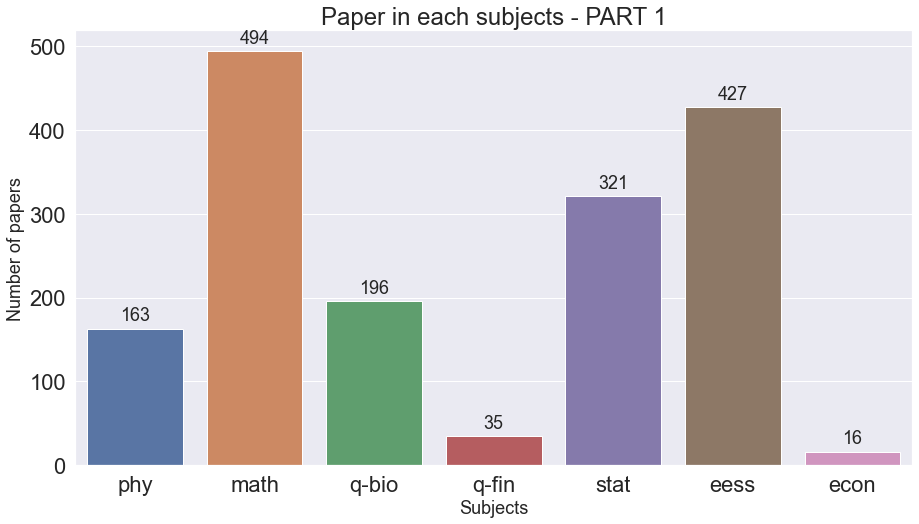

In [11]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax= sns.barplot(list(simplified_df_pt1.columns)[1:], simplified_df_pt1.iloc[:,1:].sum().values)

plt.title("Paper in each subjects - PART 1", fontsize=24)
plt.ylabel('Number of papers', fontsize=18)
plt.xlabel('Subjects', fontsize=18)

#adding the text labels
rects = ax.patches
labels = simplified_df_pt1.iloc[:,1:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

#### Split in train and test set:

In [12]:
df = simplified_df_pt1.merge(ddf.compute(), how='left', on="paper_id")
df

,paper_id,phy,math,q-bio,q-fin,stat,eess,econ,text
0,61826,0,1,0,0,0,0,0,discret restrict boltzmann machin guido montuf...
1,61836,0,0,0,0,0,0,0,knowledg matter import prior optim caglar gulc...
2,61852,0,0,0,0,0,0,0,deep learn detect robot grasp lenz honglak ash...
3,61907,0,0,0,0,0,0,0,number respons region deep feedforward network...
4,61911,0,0,0,0,0,0,0,avoid confus predictor inhibitor valu function...
...,...,...,...,...,...,...,...,...,...
15113,101196,0,0,0,0,0,0,0,model human categor natur imag deep featur rep...
15114,101198,0,0,0,0,0,0,0,oct deep cluster link discrimin model kmean ja...
15115,101216,0,0,0,0,0,0,0,beziergan automat gener smooth curv interpret ...
15116,101217,0,0,0,0,0,0,0,channel local block variant squeezeandexcit hu...


In [13]:
X_df = df.loc[:, ['paper_id','text']]
y_df = df.drop(columns=['paper_id','text'], axis=1)

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=None, random_state=0)
train_index, test_index = next(msss.split(X_df, y_df))
print(len(train_index), len(test_index))

12094 3024


In [14]:
df_train = df.iloc[train_index]
df_test = df.iloc[test_index]

X_train = tfidf_vect.transform(df.iloc[train_index]['text'])
X_test = tfidf_vect.transform(df_test['text'])
print(X_train.shape, X_test.shape)

y_train = y_df.iloc[train_index]
y_test = y_df.iloc[test_index]
print(y_train.shape, y_test.shape)

(12094, 40000) (3024, 40000)
(12094, 7) (3024, 7)


#### Classification:

In [15]:
columns=['part', 'method',
         'accuracy_train', 'precision_macro_train', 'recall_macro_train', 'f1_macro_train',
         'accuracy_test', 'precision_macro_test', 'recall_macro_test', 'f1_macro_test']
df_stat = pd.DataFrame(columns=columns)
df_stat

,part,method,accuracy_train,precision_macro_train,recall_macro_train,f1_macro_train,accuracy_test,precision_macro_test,recall_macro_test,f1_macro_test


In [16]:
labels = []
subjects = []
for l,s in enumerate(list(y_train.columns)):
    labels.append(l)
    subjects.append(s)

In [17]:
%%time
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report#, confusion_matrix, multilabel_confusion_matrix

model_modes = ['mnb', 'cnb', 'cnb_norm', 'svc', 'lr', 'dummy_rnd', 'dummy_mf', 'dummy_stf']
models = {
    'lr': {'name': 'Logistic Regression',
           'estimator': LogisticRegression(solver='sag', class_weight='balanced')
    },
    'svc': {'name': 'Linear SVC         ',
            'estimator': LinearSVC(class_weight='balanced')
    },
    'mnb': {'name': 'Multinomial NB     ',
            'estimator': MultinomialNB(fit_prior=True, class_prior=None)
    },
    'cnb': {'name': 'Complement NB      ',
            'estimator': ComplementNB(fit_prior=True, class_prior=None, norm=False)
    },
    'cnb_norm': {'name': 'Complement NB norm ',
                 'estimator': ComplementNB(fit_prior=True, class_prior=None, norm=True)
    },
    'dummy_rnd': {'name': 'Dummy Uniform      ',
                  'estimator': DummyClassifier(strategy='uniform')
    },
    'dummy_mf': {'name': 'Dummy Most-Frequent',
                 'estimator': DummyClassifier(strategy='most_frequent')
    },
    'dummy_stf': {'name': 'Dummy Stratified   ',
                 'estimator': DummyClassifier(strategy='stratified')
    }
}

logging.info("\n\n>>> TAXONOMY WITH %s SUBJECTS - PART 1\n\n" % len(subjects))

for model_mode in model_modes:
    logging.info("OneVsRest - %s" % models[model_mode]['name'])
    classifier = OneVsRestClassifier(models[model_mode]['estimator'], n_jobs=-1)
    row = {'part': 'part_1', 'method': models[model_mode]['name'].strip()}
    # TRAIN
    logging.info("... training on %s samples" % X_train.shape[0])
    classifier.fit(X_train, y_train)
    logging.info("... predicting on train set")
    prediction_train = classifier.predict(X_train)
    logging.info("\n\t\t accuracy = %s" % accuracy_score(y_train, prediction_train))
    logging.info("\n\t\t f1_macro = %s" % f1_score(y_train, prediction_train, average="macro"))
    logging.info("\n%s" % classification_report(y_train, prediction_train, labels=labels, target_names=subjects))
    row['accuracy_train'] = accuracy_score(y_train, prediction_train)
    row['precision_macro_train'] = precision_score(y_train, prediction_train, average="macro")
    row['recall_macro_train'] = recall_score(y_train, prediction_train, average="macro")
    row['f1_macro_train'] = f1_score(y_train, prediction_train, average="macro")
    # TEST
    logging.info("... predicting on test set")
    prediction_test = classifier.predict(X_test)
    logging.info("\n\t\t accuracy = %s" % accuracy_score(y_test, prediction_test))
    logging.info("\n\t\t f1_macro = %s" % f1_score(y_test, prediction_test, average="macro"))
    logging.info("\n%s" % classification_report(y_test, prediction_test, labels=labels, target_names=subjects))
    row['accuracy_test'] = accuracy_score(y_test, prediction_test)
    row['precision_macro_test'] = precision_score(y_test, prediction_test, average="macro")
    row['recall_macro_test'] = recall_score(y_test, prediction_test, average="macro")
    row['f1_macro_test'] = f1_score(y_test, prediction_test, average="macro")
    logging.info("="*60)
    # append to df_stat
    df_stat = df_stat.append(row, ignore_index=True)

Wall time: 2min 11s


## PART 2:

In [18]:
dataset_path = "../resources/papers-k-subjects-dataset.pkl"
df = pd.read_pickle(dataset_path)
df

,paper_id,primary-subject,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat.dis-nn,...,q-fin.PM,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT
0,61826,stat.ML,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,61836,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,61852,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,61907,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,61911,cs.AI,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15113,101196,cs.CV,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15114,101198,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15115,101216,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15116,101217,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Explore relations between papers and subjects:

In [19]:
def get_oneHotVector(x):
    # create dict 
    row = {'cs': 0}
    # update dict
    all_subjects = list(x.index)[2:]
    for s in taxonomy['taxonomy_pt2']['cs']['ids']:
        if s in all_subjects and x[s]==1:
            row['cs'] = 1 
            break
    # return Series
    return pd.Series(row)

columns_pt2 = ['paper_id']
columns_pt2.extend(list(taxonomy['taxonomy_pt2'].keys()))
columns_pt2.remove('cs')
simplified_df_pt2 = df.loc[:, columns_pt2]
simplified_df_pt2['cs'] = df.apply(lambda x: get_oneHotVector(x), axis=1)
simplified_df_pt2

,paper_id,cs.AI,cs.CV,cs.LG,stat.ML,cs
0,61826,0,0,0,1,0
1,61836,0,1,1,1,1
2,61852,0,1,1,0,1
3,61907,0,0,1,0,1
4,61911,1,0,0,0,0
...,...,...,...,...,...,...
15113,101196,0,1,1,1,0
15114,101198,0,1,1,1,0
15115,101216,1,0,1,1,1
15116,101217,0,1,1,1,0


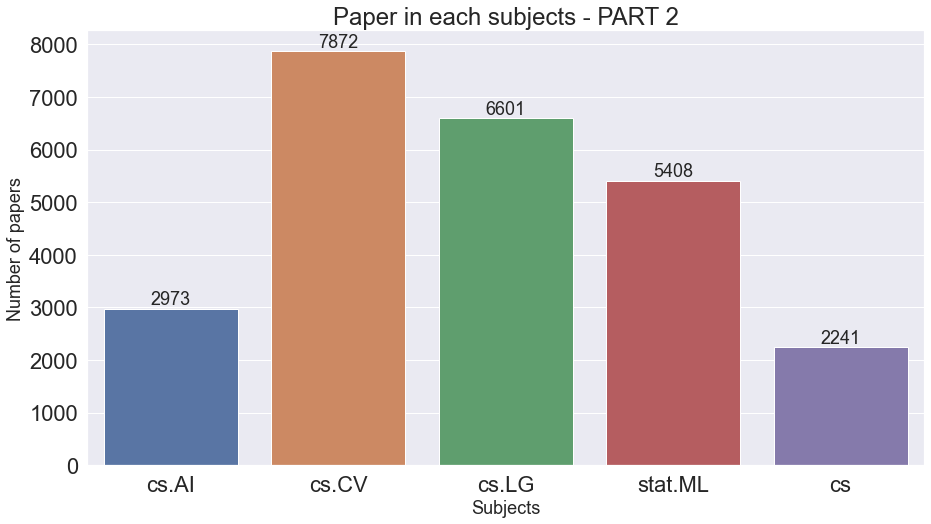

In [20]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax= sns.barplot(list(simplified_df_pt2.columns)[1:], simplified_df_pt2.iloc[:,1:].sum().values)

plt.title("Paper in each subjects - PART 2", fontsize=24)
plt.ylabel('Number of papers', fontsize=18)
plt.xlabel('Subjects', fontsize=18)

#adding the text labels
rects = ax.patches
labels = simplified_df_pt2.iloc[:,1:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

#### Split in train and test set:

In [21]:
df = simplified_df_pt2.merge(ddf.compute(), how='left', on="paper_id")
df

,paper_id,cs.AI,cs.CV,cs.LG,stat.ML,cs,text
0,61826,0,0,0,1,0,discret restrict boltzmann machin guido montuf...
1,61836,0,1,1,1,1,knowledg matter import prior optim caglar gulc...
2,61852,0,1,1,0,1,deep learn detect robot grasp lenz honglak ash...
3,61907,0,0,1,0,1,number respons region deep feedforward network...
4,61911,1,0,0,0,0,avoid confus predictor inhibitor valu function...
...,...,...,...,...,...,...,...
15113,101196,0,1,1,1,0,model human categor natur imag deep featur rep...
15114,101198,0,1,1,1,0,oct deep cluster link discrimin model kmean ja...
15115,101216,1,0,1,1,1,beziergan automat gener smooth curv interpret ...
15116,101217,0,1,1,1,0,channel local block variant squeezeandexcit hu...


In [22]:
X_df = df.loc[:, ['paper_id','text']]
y_df = df.drop(columns=['paper_id','text'], axis=1)

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=None, random_state=0)
train_index, test_index = next(msss.split(X_df, y_df))
print(len(train_index), len(test_index))

12078 3040


In [23]:
df_train = df.iloc[train_index]
df_test = df.iloc[test_index]

X_train = tfidf_vect.transform(df.iloc[train_index]['text'])
X_test = tfidf_vect.transform(df_test['text'])
print(X_train.shape, X_test.shape)

y_train = y_df.iloc[train_index]
y_test = y_df.iloc[test_index]
print(y_train.shape, y_test.shape)

(12078, 40000) (3040, 40000)
(12078, 5) (3040, 5)


#### Classification:

In [24]:
labels = []
subjects = []
for l,s in enumerate(list(y_train.columns)):
    labels.append(l)
    subjects.append(s)

In [25]:
logging.info("\n\n>>> TAXONOMY WITH %s SUBJECTS - PART 2\n\n" % len(subjects))

for model_mode in model_modes:
    logging.info("OneVsRest - %s" % models[model_mode]['name'])
    classifier = OneVsRestClassifier(models[model_mode]['estimator'], n_jobs=-1)
    row = {'part': 'part_2', 'method': models[model_mode]['name'].strip()}
    # TRAIN
    logging.info("... training on %s samples" % X_train.shape[0])
    classifier.fit(X_train, y_train)
    logging.info("... predicting on train set")
    prediction_train = classifier.predict(X_train)
    logging.info("\n\t\t accuracy = %s" % accuracy_score(y_train, prediction_train))
    logging.info("\n\t\t f1_macro = %s" % f1_score(y_train, prediction_train, average="macro"))
    logging.info("\n%s" % classification_report(y_train, prediction_train, labels=labels, target_names=subjects))
    row['accuracy_train'] = accuracy_score(y_train, prediction_train)
    row['precision_macro_train'] = precision_score(y_train, prediction_train, average="macro")
    row['recall_macro_train'] = recall_score(y_train, prediction_train, average="macro")
    row['f1_macro_train'] = f1_score(y_train, prediction_train, average="macro")
    # TEST
    logging.info("... predicting on test set")
    prediction_test = classifier.predict(X_test)
    logging.info("\n\t\t accuracy = %s" % accuracy_score(y_test, prediction_test))
    logging.info("\n\t\t f1_macro = %s" % f1_score(y_test, prediction_test, average="macro"))
    logging.info("\n%s" % classification_report(y_test, prediction_test, labels=labels, target_names=subjects))
    row['accuracy_test'] = accuracy_score(y_test, prediction_test)
    row['precision_macro_test'] = precision_score(y_test, prediction_test, average="macro")
    row['recall_macro_test'] = recall_score(y_test, prediction_test, average="macro")
    row['f1_macro_test'] = f1_score(y_test, prediction_test, average="macro")
    logging.info("="*60)
    # append to df_stat
    df_stat = df_stat.append(row, ignore_index=True)

## RESULTS:

In [26]:
df_stat

,part,method,accuracy_train,precision_macro_train,recall_macro_train,f1_macro_train,accuracy_test,precision_macro_test,recall_macro_test,f1_macro_test
0,part_1,Multinomial NB,0.901356,0.107143,0.001085,0.002148,0.900463,0.000000,0.000000,0.000000
1,part_1,Complement NB,0.901439,0.088670,0.013020,0.022706,0.902447,0.107143,0.017316,0.029814
2,part_1,Complement NB norm,0.901439,0.142857,0.001085,0.002154,0.900463,0.000000,0.000000,0.000000
3,part_1,Linear SVC,0.980404,0.883895,1.000000,0.936806,0.880622,0.380435,0.298282,0.324375
4,part_1,Logistic Regression,0.577559,0.160438,0.897187,0.252475,0.553902,0.118397,0.651154,0.185506
5,part_1,Dummy Uniform,0.901191,0.000000,0.000000,0.000000,0.900463,0.000000,0.000000,0.000000
6,part_1,Dummy Most-Frequent,0.901191,0.000000,0.000000,0.000000,0.900463,0.000000,0.000000,0.000000
7,part_1,Dummy Stratified,0.808748,0.013946,0.013709,0.013824,0.819775,0.014663,0.014239,0.014435
8,part_2,Multinomial NB,0.598278,0.864003,0.637394,0.675106,0.575658,0.828683,0.630467,0.663770
9,part_2,Complement NB,0.597615,0.794388,0.727974,0.745957,0.575329,0.766139,0.711052,0.723149
